In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp

#Read in data frame and make the date column in the datetime64 data type
us_vaccinations = pd.read_csv('us_state_vaccinations.csv', parse_dates=['date'])
#Output is a cleaned vaccination df 

#Read in voting data set, set the index to the State/District and replace all the '$' with nan
us_voting = pd.read_csv("Voting States.csv").set_index('State/District').replace('$', np.nan)
#Output is a cleaned voting dataset


In [ ]:
#Create function that takes in a dataframe, state name, and column name and returns a pandas series of the total_vaccinations indexed by date
def return_state_data (state, data=us_vaccinations, column='total_vaccinations'):
    data = data.set_index('date')
    data = data[data['location'] == state]
    series = data[column]
    return series
#Output is a pandas series of states total vaccinations indexed by date

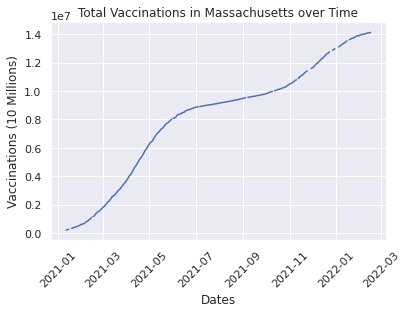

In [ ]:
#Plot a Massachusetts total vaccination data over time  with title and axis labeled
state = 'Massachusetts'
state_vaccinations = return_state_data(state)

sns.set_theme()
plt.plot(state_vaccinations)
plt.xlabel('Dates')
plt.xticks(rotation = 45)
plt.ylabel('Vaccinations (10 Millions)')
plt.title(f'Total Vaccinations in {state} over Time')

plt.show()
#Output is a matplotlib graph

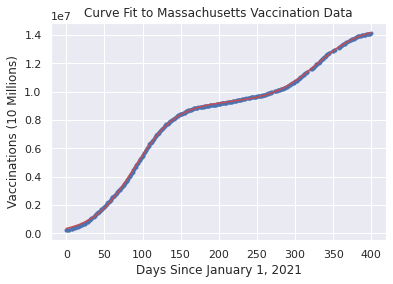

[9292199.161864705,
 0.036416388107538715,
 89.35748370448829,
 5319024.076485054,
 0.03382990386710977,
 328.23476811678034]

In [ ]:
#Create a funciton that inputs a state and optimizes/fits this data to a logistic function.
#Give the option to plot this line on the state data to compare and return the 6 produced by our model.
def optimize_model(state, data=us_vaccinations, column='total_vaccinations', show=False):
    
    def better_model ( x, β0, β1, β2, β3, β4, β5 ):
        return (β0 / (1+ np.exp(β1*(-x+β2)))) + (β3 / (1+ np.exp(β4*(-x+β5))))

    vaccination_series = return_state_data(state).reset_index(drop=True).dropna()

    β0, β1, β2,β3,β4, β5 = vaccination_series.max()/2, 1, len(vaccination_series) / 2, \
    vaccination_series.max()/2, 1, len(vaccination_series) * 3/4

    found_betas, covariance = curve_fit( better_model, vaccination_series.index,\
     vaccination_series, p0=[β0, β1, β2,β3,β4, β5], maxfev=10000 )
    β0, β1, β2,β3,β4, β5 = found_betas

    fit_model = lambda x: better_model( x, β0, β1, β2, β3,β4, β5)

    if show == True:
        plt.plot(vaccination_series, marker = '.')
        plt.plot(vaccination_series.index, fit_model(vaccination_series.index), color='r')
        plt.title(f'Curve Fit to {state} Vaccination Data')
        plt.xlabel('Days Since January 1, 2021')
        plt.ylabel('Vaccinations (10 Millions)')
        plt.show()

    return [β0, β1, β2,β3,β4, β5]

optimize_model('Massachusetts', show=True)
#Figure below shows our function displayed across the actual state data to see that our model is a near perfect fit.

In [ ]:
#Use a list comprehension to create a list of lists with the first element in the list 
#being the state name and the rest are the betas obtained by running our optimize_model function.

beta_list = [[x] + optimize_model(x) for x in us_vaccinations['location'].unique()]

#Create dataframe by inputting the "beta_list" we created and specifying corresponding column names
#Merge this dataframe with the "D-%" column from the us_voting dataframe, set index as state, and rename the new column "Dem. Votes"

beta_df = pd.DataFrame(beta_list, columns=['State', 'β0', 'β1', 'β2', 'β3','β4', 'β5']) \
.merge(us_voting['D-%'], left_on='State', right_on='State/District').set_index('State') \
.rename(columns={'D-%':'Dem. Votes'})

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


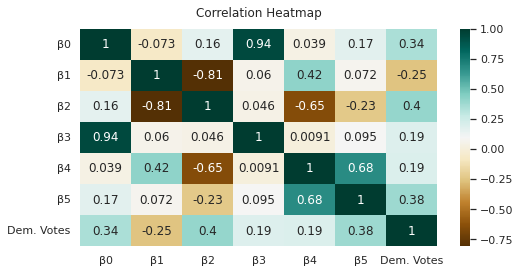

In [ ]:
#Create a heatmap using seaborn, change the figure size so the numbers are displayed better, change the color so it is more visable,
#add a title.
plt.figure(figsize=(8, 4))


heatmap = sns.heatmap(beta_df.corr(), annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8364c9e9-ec80-4cd3-82ba-33c98959f759' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>